In [1]:
pip install prophet matplotlib seaborn pandas numpy scikit-learn  pymongo

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# Cell 1: Imports and Global Configurations

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
from pymongo import MongoClient # For MongoDB connection

# --- Global Configurations ---
CITY_FOCUS = "Lahore"

# Set plot style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('viridis')

C:\Users\KHILJI\AppData\Roaming\Python\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [3]:
# Cell 2: MongoDB Atlas Credentials (***IMPORTANT: Fill in your actual cluster name and confirm DB/Collection***)

MONGO_USER = "MHK_Technologies"
MONGO_PASSWORD = "nISQuhdTNSo1N7Lq" # Your actual password you provided earlier
MONGO_CLUSTER_NAME = "cluster0.lgzcnm2.mongodb.net" # THIS IS THE UPDATED LINE
MONGO_DB_NAME = "weather_aqi_db" # The database name you created in Atlas for this project
MONGO_COLLECTION_NAME = "city_data" # The collection name where your AQI and weather data is stored

# MongoDB Atlas Connection String (SRV format is recommended)
MONGO_CONNECTION_STRING = (
    f"mongodb+srv://{MONGO_USER}:{MONGO_PASSWORD}@{MONGO_CLUSTER_NAME}/"
    f"{MONGO_DB_NAME}?retryWrites=true&w=majority"
)

print("MongoDB Atlas connection string configured. Remember to replace <cluster_name>.")
print("Ensure your MongoDB Atlas network access is configured to allow your IP address.")

MongoDB Atlas connection string configured. Remember to replace <cluster_name>.
Ensure your MongoDB Atlas network access is configured to allow your IP address.


In [4]:
# Cell 3: Data Loading and Preparation Function (MongoDB Atlas)

def load_and_prepare_aqi_data(source='db', num_dummy_periods=24 * 90):
    """
    Loads AQI and Weather data from the specified source (MongoDB Atlas or dummy).
    Prophet requires columns named 'ds' (datetime) and 'y' (value).
    """
    if source == 'db':
        print(f"Connecting to MongoDB Atlas database '{MONGO_DB_NAME}' collection '{MONGO_COLLECTION_NAME}'...")
        try:
            from pymongo import MongoClient # Ensure MongoClient is imported here as well for safety
            client = MongoClient(MONGO_CONNECTION_STRING)
            db = client[MONGO_DB_NAME]
            collection = db[MONGO_COLLECTION_NAME]
            
            # --- STEP 1: Fetch ALL documents from the collection ---
            print(f"Fetching ALL documents from collection: {MONGO_COLLECTION_NAME} (sorted by timestamp)...")
            # We remove the city filter here to fetch everything
            cursor = collection.find({}).sort("timestamp", 1) 
            
            # Convert MongoDB cursor to a Pandas DataFrame
            df_raw = pd.DataFrame(list(cursor))
            
            if df_raw.empty:
                raise ValueError(f"Collection '{MONGO_COLLECTION_NAME}' in database '{MONGO_DB_NAME}' is empty or does not exist.")

            print(f"Successfully loaded {df_raw.shape[0]} documents from MongoDB. Now filtering for city: {CITY_FOCUS}...")

            # --- STEP 2: Filter by city in Pandas ---
            # Ensure 'city' column exists and filter
            if 'city' not in df_raw.columns:
                raise ValueError(f"No 'city' column found in documents from collection '{MONGO_COLLECTION_NAME}'. Cannot filter.")
            
            # Filter for the specific city. Make sure 'city' values are strings for comparison.
            df_city_filtered = df_raw[df_raw['city'].astype(str) == CITY_FOCUS].copy()
            
            if df_city_filtered.empty:
                raise ValueError(f"No data found for city '{CITY_FOCUS}' in collection '{MONGO_COLLECTION_NAME}' after loading all data. Check city name casing or if data exists.")

            # Rename columns for Prophet and ensure correct types
            # *** UPDATED LINE HERE: 'aqi' is now correctly mapped to 'y' ***
            df_city_filtered.rename(columns={'timestamp': 'ds', 'aqi': 'y'}, inplace=True)
            
            df_city_filtered['ds'] = pd.to_datetime(df_city_filtered['ds']) # Ensure 'ds' is datetime
            df_city_filtered['y'] = pd.to_numeric(df_city_filtered['y'], errors='coerce') # Ensure 'y' is numeric

            # Ensure weather regressors are numeric
            regressor_cols = ['temperature', 'humidity', 'wind_speed']
            for col in regressor_cols:
                if col in df_city_filtered.columns:
                    df_city_filtered[col] = pd.to_numeric(df_city_filtered[col], errors='coerce')
                else:
                    print(f"Warning: MongoDB document does not contain expected regressor '{col}'. Skipping.")
            
            # Drop rows with NaNs in critical columns (ds, y, and specified regressors)
            initial_rows = df_city_filtered.shape[0]
            # Select columns that are essential for the model and check for NaNs
            cols_to_check = ['ds', 'y'] + [col for col in regressor_cols if col in df_city_filtered.columns]
            df_city_filtered.dropna(subset=cols_to_check, inplace=True)

            if df_city_filtered.shape[0] < initial_rows:
                print(f"Dropped {initial_rows - df_city_filtered.shape[0]} rows due to missing values in critical columns.")

            # Prophet expects 'ds' to be sorted
            df_city_filtered.sort_values('ds', inplace=True)
            
            print(f"Successfully loaded and filtered {df_city_filtered.shape[0]} documents from MongoDB for {CITY_FOCUS}.")
            print("Columns available:", df_city_filtered.columns.tolist())
            
            # Close the connection
            client.close()
            
            return df_city_filtered

        except Exception as e:
            print(f"Error connecting to MongoDB Atlas or fetching data: {e}")
            print("Falling back to dummy data for demonstration.")
            # Explicitly make a deep copy when returning dummy data
            return load_and_prepare_aqi_data(source='dummy', num_dummy_periods=num_dummy_periods).copy()

    elif source == 'dummy':
        print(f"Generating dummy data for {num_dummy_periods} periods...")
        start_date = pd.to_datetime('2024-01-01 00:00:00')
        # Corrected freq='H' to freq='h' to avoid FutureWarning
        dates = pd.date_range(start=start_date, periods=num_dummy_periods, freq='h') 

        base_aqi = 50 + np.linspace(0, 100, num_dummy_periods)
        daily_seasonality = 30 * np.sin(dates.hour * (2 * np.pi / 24))
        weekly_seasonality = 15 * np.sin(dates.dayofweek * (2 * np.pi / 7))
        noise = np.random.normal(loc=0, scale=10, size=num_dummy_periods)
        aqi_y = base_aqi + daily_seasonality + weekly_seasonality + noise

        anomaly_indices = np.random.choice(range(50, num_dummy_periods - 50), 5, replace=False)
        for idx in anomaly_indices:
            aqi_y[idx:idx+3] += np.random.randint(50, 200)

        temperature = 25 + 10 * np.sin(dates.dayofyear * (2 * np.pi / 365)) + np.random.normal(0, 3, num_dummy_periods)
        humidity = 60 + 15 * np.cos(dates.hour * (2 * np.pi / 24)) + np.random.normal(0, 5, num_dummy_periods)
        wind_speed = 5 + 3 * np.random.rand(num_dummy_periods)
        low_wind_indices = np.random.choice(range(50, num_dummy_periods - 50), 3, replace=False)
        for idx in low_wind_indices:
            wind_speed[idx:idx+5] = np.random.uniform(0.5, 2, 5)

        df = pd.DataFrame({
            'ds': dates,
            'y': aqi_y.round(2),
            'temperature': temperature.round(1),
            'humidity': humidity.round(1),
            'wind_speed': wind_speed.round(1),
            'city': CITY_FOCUS
        })
        df['ds'] = pd.to_datetime(df['ds'])
        
        # Ensure df is sorted by 'ds' for Prophet
        df.sort_values('ds', inplace=True)

        print(f"Generated dummy data for {num_dummy_periods} periods.")
        print("Columns available:", df.columns.tolist())
        return df
    else:
        raise ValueError("Invalid data source specified. Use 'db' or 'dummy'.")

In [5]:
# Cell 4: Exploratory Data Analysis (EDA) Function

def perform_eda(df):
    """
    Performs basic EDA on the loaded DataFrame.
    """
    print("\n--- Performing EDA ---")
    print("DataFrame Info:")
    df.info()
    print("\nFirst 5 rows:")
    print(df.head())
    print("\nDescriptive statistics for 'y' (AQI):")
    print(df['y'].describe())
    
    # Visualize 'y' (AQI) over time
    plt.figure(figsize=(18, 7))
    plt.plot(df['ds'], df['y'], label='AQI (y)', color='blue', alpha=0.7)
    plt.title(f'AQI Over Time in {CITY_FOCUS}', size=18)
    plt.xlabel('Timestamp', size=14)
    plt.ylabel('AQI Value', size=14)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Visualize distribution of 'y' (AQI)
    plt.figure(figsize=(10, 5))
    sns.histplot(df['y'], kde=True)
    plt.title(f'Distribution of AQI (y) in {CITY_FOCUS}', size=16)
    plt.xlabel('AQI Value', size=14)
    plt.ylabel('Frequency', size=14)
    plt.tight_layout()
    plt.show()

    # Visualize weather parameters over time
    weather_cols = ['temperature', 'humidity', 'wind_speed']
    fig, axes = plt.subplots(len(weather_cols), 1, figsize=(18, 5 * len(weather_cols)), sharex=True)
    fig.suptitle(f'Weather Parameters Over Time in {CITY_FOCUS}', size=20, y=1.02)
    
    for i, col in enumerate(weather_cols):
        if col in df.columns:
            axes[i].plot(df['ds'], df[col], label=col, color=sns.color_palette('viridis')[i])
            axes[i].set_ylabel(col.replace('_', ' ').title(), size=14)
            axes[i].grid(True)
            axes[i].legend(loc='upper right')
    
    axes[-1].set_xlabel('Timestamp', size=14)
    plt.tight_layout(rect=[0, 0.03, 1, 0.98]) # Adjust layout to prevent title overlap
    plt.show()

In [6]:
# Cell 5: Train Prophet Model Function

def train_prophet_model(df, yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=True, growth='linear'):
    """
    Trains a Prophet model on the prepared DataFrame, including weather regressors.
    """
    print("\n--- Training Prophet Model ---")
    
    model = Prophet(
        yearly_seasonality=yearly_seasonality,
        weekly_seasonality=weekly_seasonality,
        daily_seasonality=daily_seasonality,
        growth=growth, # 'linear' or 'logistic'
        interval_width=0.95 # Confidence interval for predictions (e.g., 95%)
    )
    
    # Add weather regressors
    # These columns MUST exist in your 'df' used for training AND in the 'future' DataFrame for prediction.
    if 'temperature' in df.columns:
        model.add_regressor('temperature')
    if 'humidity' in df.columns:
        model.add_regressor('humidity')
    if 'wind_speed' in df.columns:
        model.add_regressor('wind_speed')
    
    # --- Optional: Add custom holidays for Pakistan ---
    # from prophet.make_holidays import make_holidays_df
    # You might need to install 'holidays' package if it's not already by Prophet
    # holidays = make_holidays_df(year_list=range(2023, 2026), country='PK') # Adjust years as needed
    # model.holidays = holidays
    # print("Added Pakistan holidays to model.")

    print("Fitting Prophet model with weather regressors...")
    model.fit(df)
    print("Prophet model trained successfully.")
    return model

In [7]:
# Cell 6: Forecast and Detect Anomalies Function

def forecast_and_detect_anomalies(model, df, periods_to_forecast=0, freq='H'):
    """
    Generates forecasts using the trained Prophet model and identifies anomalies.
    'periods_to_forecast': Number of future periods to forecast (e.g., 24 for next day).
                           If 0, forecasts for the training period.
    'freq': Frequency of your data (e.g., 'H' for hourly, 'D' for daily).
    """
    print(f"\n--- Generating Forecasts and Detecting Anomalies for {periods_to_forecast} future periods ---")

    # Create a future DataFrame for forecasting
    future = model.make_future_dataframe(periods=periods_to_forecast, freq=freq, include_history=True)
    
    # Add regressors to the future DataFrame
    # For historical 'future' points (include_history=True), we use existing data.
    # For actual future points, you'd need forecasted weather data or real-time measurements.
    # For now, we'll reindex historical weather data to match 'future' ds
    # For truly future periods, you'd need to provide predicted weather data.
    
    regressor_cols = ['temperature', 'humidity', 'wind_speed']
    for col in regressor_cols:
        if col in df.columns:
            # Reindex historical weather data for known periods
            future[col] = df.set_index('ds')[col].reindex(future['ds'])
            
            # For any periods where reindex resulted in NaN (i.e., true future periods)
            # You would need a strategy to fill these:
            # 1. Use forecasted weather data (e.g., from a separate weather forecasting model)
            # 2. Use last known value (less accurate for long forecasts)
            # 3. Use average/seasonal average (simplistic)
            # For this demo, we'll fill with mean for future, assuming it's short-term.
            if future[col].isnull().any():
                 future[col] = future[col].fillna(df[col].mean()) # Simple fill for future, replace with real forecasts later!
                 print(f"Warning: Filled future '{col}' values with mean for forecasting. Replace with actual forecasts!")
        else:
            print(f"Warning: Regressor column '{col}' not found in data.")


    print(f"Generating forecast for {len(future)} periods...")
    forecast = model.predict(future)
    print("Forecast generated.")
    
    # Merge original 'y' data with forecast to compare and identify anomalies
    # Use 'left' merge to keep all original 'y' values
    df_with_forecast = pd.merge(df[['ds', 'y']], forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']], on='ds', how='left')

    # Identify anomalies: actual 'y' outside 'yhat_lower' and 'yhat_upper'
    df_with_forecast['anomaly'] = 0 # 0 for normal
    df_with_forecast.loc[df_with_forecast['y'] < df_with_forecast['yhat_lower'], 'anomaly'] = -1 # Low anomaly
    df_with_forecast.loc[df_with_forecast['y'] > df_with_forecast['yhat_upper'], 'anomaly'] = 1 # High anomaly
    
    print(f"Total historical anomalies detected: {df_with_forecast[df_with_forecast['anomaly'] != 0].shape[0]}")
    
    return df_with_forecast, forecast

In [ ]:
# Cell 5: Visualization Function

import matplotlib.pyplot as plt
import seaborn as sns
# prophet.plot is often imported for convenience, but specific functions are better
from prophet.plot import plot_plotly, plot_components_plotly # These are typically used for interactive plots

def visualize_prophet_anomalies(df_results, full_forecast, model): # <-- Added 'model' here to accept 3 arguments
    """
    Visualizes the Prophet forecast, anomalies, and model components.
    """
    print("\n--- Generating Forecast and Anomaly Plots ---")

    # Plot the main forecast with actuals and anomaly points
    fig1 = model.plot(full_forecast)
    plt.title('Prophet Forecast with Anomalies')
    plt.xlabel('Date')
    plt.ylabel('AQI Value')

    # Add anomalies to the plot
    # Anomalies where 'anomaly' is 1 (positive) or -1 (negative)
    historical_anomalies = df_results[df_results['anomaly'] != 0]
    if not historical_anomalies.empty:
        plt.scatter(historical_anomalies['ds'],
                    historical_anomalies['y'],
                    color='red', marker='o', s=50, label='Anomaly')
    
    plt.legend()
    plt.show()

    # Plot the components of the model (trend, yearly, weekly, daily seasonality)
    # This will show very little with minimal data, but it's part of the standard process.
    fig2 = model.plot_components(full_forecast)
    plt.suptitle('Prophet Model Components', y=1.02) # Adjust suptitle position if needed
    plt.tight_layout(rect=[0, 0, 1, 0.98]) # Adjust layout to prevent title overlap
    plt.show()

    # --- Optional: Interactive Plotly Plots (Uncomment if you have Plotly installed) ---
    # These provide zoom and hover capabilities, but require 'plotly' package.
    # If you want to use them, run: pip install plotly
    # try:
    #     fig_interactive_forecast = plot_plotly(model, full_forecast)
    #     fig_interactive_forecast.show()
    #     fig_interactive_components = plot_components_plotly(model, full_forecast)
    #     fig_interactive_components.show()
    # except ImportError:
    #     print("Plotly not installed. Skipping interactive plots. Install with: pip install plotly")
    # except Exception as e:
    #     print(f"Error generating interactive plots (likely due to insufficient data for Plotly's rendering logic): {e}")

    print("Plots generated. Note: Plots may look sparse or simple due to limited data.")

Connecting to MongoDB Atlas database 'weather_aqi_db' collection 'city_data'...
Fetching ALL documents from collection: city_data (sorted by timestamp)...
Successfully loaded 102 documents from MongoDB. Now filtering for city: Lahore...
Successfully loaded and filtered 17 documents from MongoDB for Lahore.
Columns available: ['_id', 'city', 'latitude', 'longitude', 'temperature', 'humidity', 'wind_speed', 'conditions', 'y', 'co', 'no', 'no2', 'o3', 'so2', 'pm2_5', 'pm10', 'nh3', 'ds']

--- Performing EDA ---
DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
Index: 17 entries, 3 to 97
Data columns (total 18 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   _id          17 non-null     object        
 1   city         17 non-null     object        
 2   latitude     17 non-null     float64       
 3   longitude    17 non-null     float64       
 4   temperature  17 non-null     float64       
 5   humidity     17 non-null

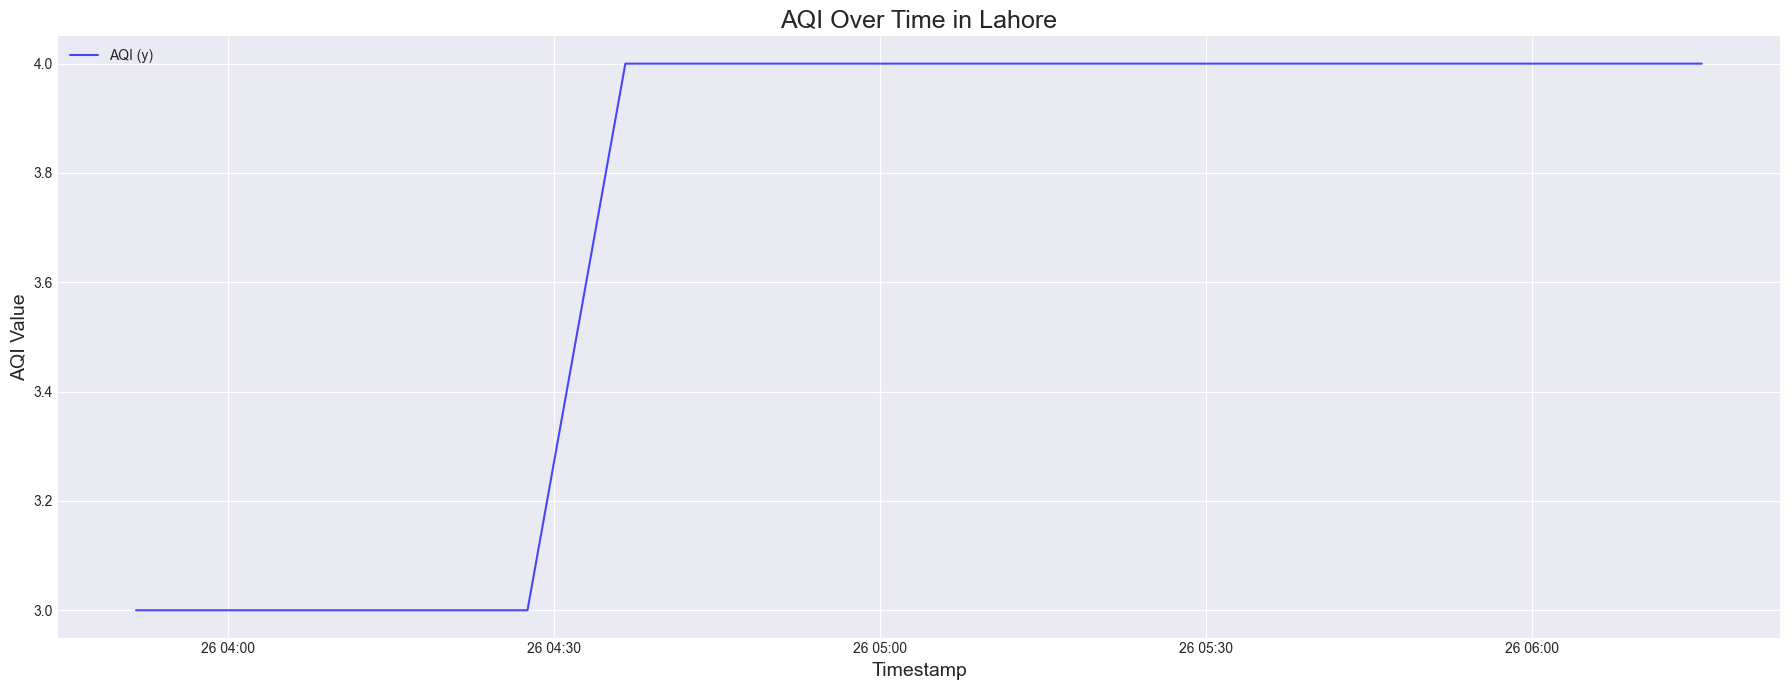

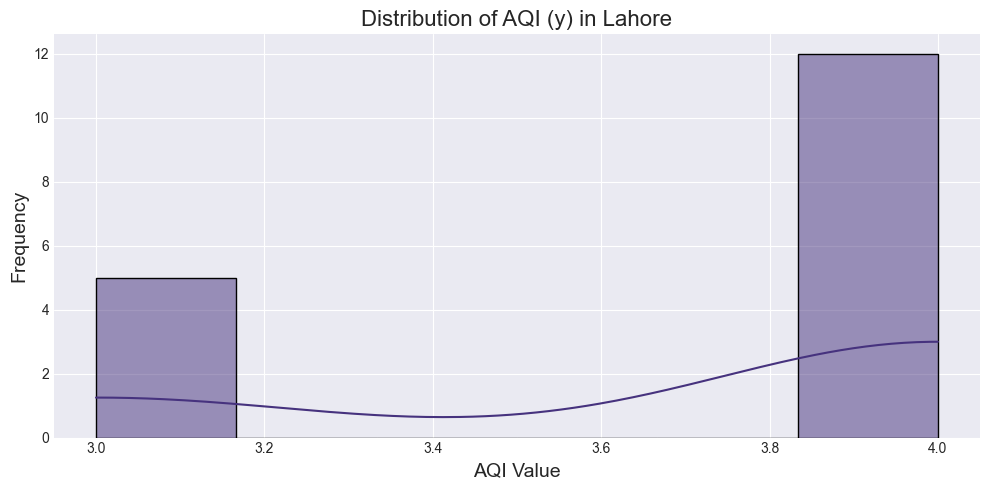

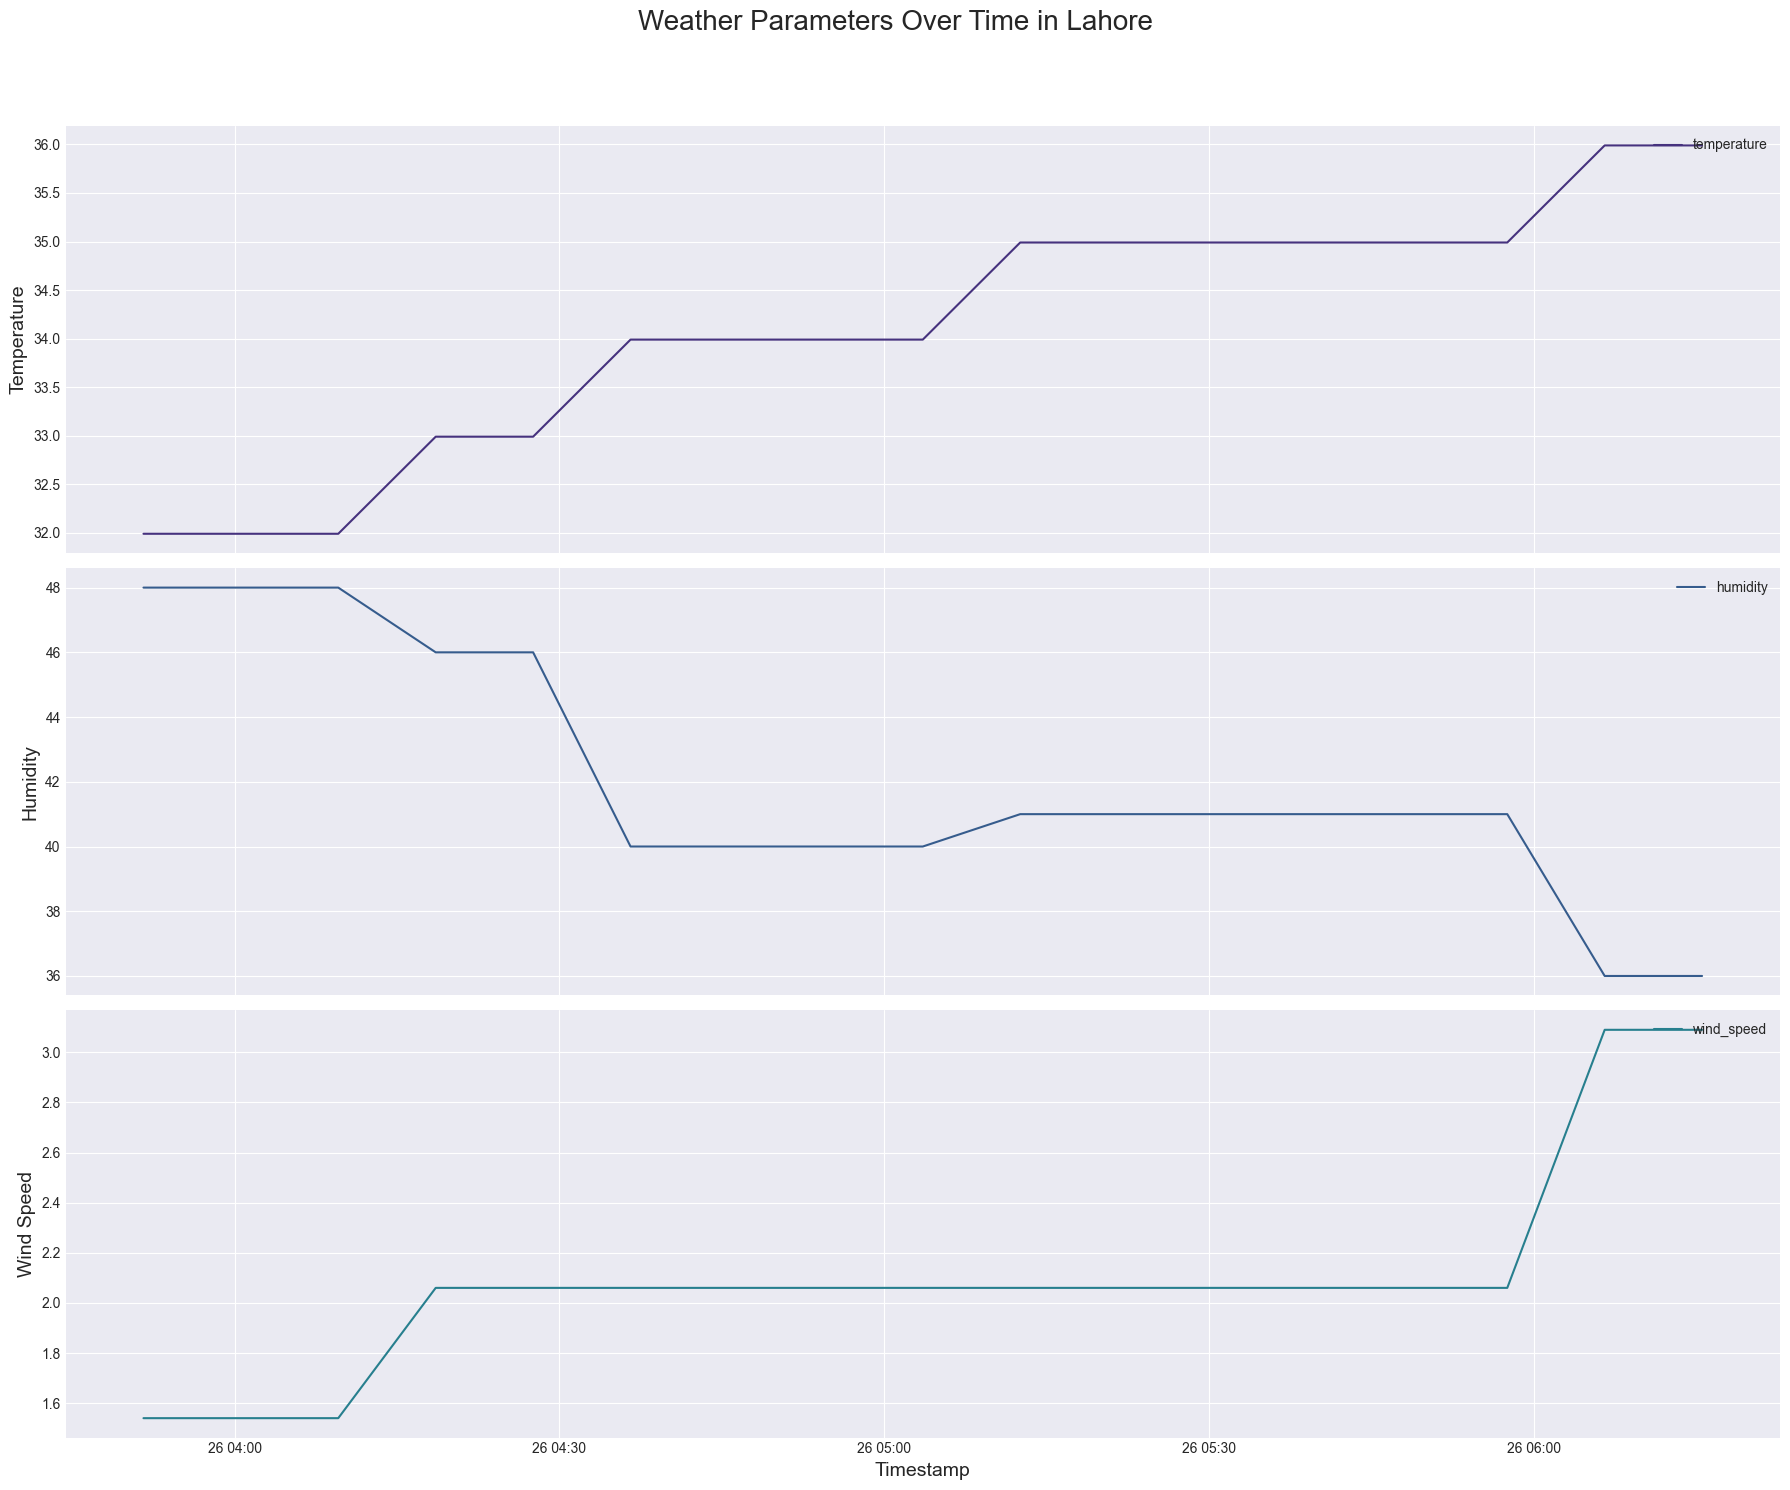


--- Training Prophet Model ---
Fitting Prophet model with weather regressors...


11:23:35 - cmdstanpy - INFO - Chain [1] start processing
11:23:36 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\KHILJI\AppData\Roaming\Python\Python312\site-packages\prophet\forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(


Prophet model trained successfully.

--- Generating Forecasts and Detecting Anomalies for 0 future periods ---
Generating forecast for 17 periods...
Forecast generated.
Total historical anomalies detected: 17

--- Detected Anomalies (first 10) ---
                       ds  y      yhat  yhat_lower  yhat_upper  anomaly
0 2025-05-26 03:51:34.515  3  3.704742    3.704742    3.704742       -1
1 2025-05-26 04:00:34.473  3  3.704741    3.704741    3.704741       -1
2 2025-05-26 04:09:34.301  3  3.704739    3.704739    3.704739       -1
3 2025-05-26 04:18:34.470  3  3.708174    3.708174    3.708174       -1
4 2025-05-26 04:27:34.496  3  3.708172    3.708172    3.708172       -1
5 2025-05-26 04:36:34.499  4  3.707250    3.707250    3.707250        1
6 2025-05-26 04:45:34.510  4  3.707248    3.707248    3.707248        1
7 2025-05-26 04:54:34.324  4  3.707246    3.707246    3.707246        1
8 2025-05-26 05:03:34.601  4  3.707243    3.707243    3.707243        1
9 2025-05-26 05:12:34.534  4  3.

TypeError: visualize_prophet_anomalies() takes 2 positional arguments but 3 were given

In [9]:
# Cell 8: Main Execution Block

if __name__ == "__main__":
    # Load and prepare data (attempting DB first, fallback to dummy)
    # Adjust num_dummy_periods as needed if you use dummy data for longer periods
    df_prepared = load_and_prepare_aqi_data(source='db', num_dummy_periods=24 * 365 * 2) # e.g., 2 years of hourly data if dummy

    if not df_prepared.empty:
        # Perform EDA
        perform_eda(df_prepared)
        
        # Train Prophet model
        # You can adjust seasonality parameters based on your EDA
        model = train_prophet_model(df_prepared,
                                    yearly_seasonality=True,
                                    weekly_seasonality=True,
                                    daily_seasonality=True)
        
        # Forecast and detect anomalies on the historical data
        # For real-time, you'd feed new data points and predict for 1 period (next hour/minute)
        df_results, full_forecast = forecast_and_detect_anomalies(model, df_prepared, periods_to_forecast=0)
        
        # Display detected anomalies
        print("\n--- Detected Anomalies (first 10) ---")
        historical_anomalies = df_results[df_results['anomaly'] != 0]
        if not historical_anomalies.empty:
            print(historical_anomalies.head(10))
            # You can save these anomalies to your MongoDB Atlas here for review later
            # from pymongo import MongoClient
            # client = MongoClient(MONGO_CONNECTION_STRING)
            # db = client[MONGO_DB_NAME]
            # anomalies_collection = db['aqi_anomalies_log'] # New collection for anomalies
            # anomalies_to_insert = historical_anomalies[['ds', 'y', 'yhat_lower', 'yhat_upper', 'anomaly']].to_dict(orient='records')
            # # Ensure 'ds' is stored as datetime in MongoDB
            # for record in anomalies_to_insert:
            #     record['ds'] = record['ds'].to_pydatetime()
            # anomalies_collection.insert_many(anomalies_to_insert)
            # print("Anomalies logged to MongoDB.")
            # client.close()
        else:
            print("No anomalies detected in historical data.")


        # Visualize results - ***UPDATED LINE HERE***
        visualize_prophet_anomalies(df_results, full_forecast, model) 
        
        print("\nProphet-based AQI Anomaly Detection process complete for the loaded data.")
        print("Next steps: Refine data loading for real-time, implement streaming prediction, and integrate with Django UI.")
    else:
        print("No data loaded. Cannot proceed with model training.")